# COMPAS Dataset Bias Audit  
This notebook presents a bias audit on the COMPAS dataset using Python and fairness metrics.

---

**Objective:**  
Investigate potential algorithmic bias with respect to race and gender in criminal risk assessments.

**Tools Used:**  
- Pandas
- AIF360 (AI Fairness 360)
- Matplotlib & Seaborn

---



In [17]:
import matplotlib.pyplot as plt


In [8]:
from aif360.metrics import BinaryLabelDatasetMetric


pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [2]:
from aif360.datasets import CompasDataset
import pandas as pd


In [1]:
# If not already installed, uncomment the line below to install AI Fairness 360
# !pip install aif360

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from aif360.datasets import CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")


pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [5]:
# Load the COMPAS dataset using AIF360's built-in loader
dataset_orig = CompasDataset()

# Display first few rows of the dataset
df = dataset_orig.convert_to_dataframe()[0]
df.head()


,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,age_cat=25 - 45,age_cat=Greater than 45,age_cat=Less than 25,...,c_charge_desc=Viol Injunct Domestic Violence,c_charge_desc=Viol Injunction Protect Dom Vi,c_charge_desc=Viol Pretrial Release Dom Viol,c_charge_desc=Viol Prot Injunc Repeat Viol,c_charge_desc=Violation License Restrictions,c_charge_desc=Violation Of Boater Safety Id,c_charge_desc=Violation of Injunction Order/Stalking/Cyberstalking,c_charge_desc=Voyeurism,c_charge_desc=arrest case no charge,two_year_recid
1,0.0,69.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,34.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,24.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,0.0,44.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,41.0,1.0,0.0,0.0,0.0,14.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [6]:
print("Features:", dataset_orig.feature_names)
print("Protected Attribute:", dataset_orig.protected_attribute_names)
print("Privileged Class:", dataset_orig.privileged_protected_attributes)
print("Unprivileged Class:", dataset_orig.unprivileged_protected_attributes)


Features: ['sex', 'age', 'race', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'age_cat=25 - 45', 'age_cat=Greater than 45', 'age_cat=Less than 25', 'c_charge_degree=F', 'c_charge_degree=M', 'c_charge_desc=Abuse Without Great Harm', 'c_charge_desc=Agg Abuse Elderlly/Disabled Adult', 'c_charge_desc=Agg Assault W/int Com Fel Dome', 'c_charge_desc=Agg Battery Grt/Bod/Harm', 'c_charge_desc=Agg Fleeing and Eluding', 'c_charge_desc=Agg Fleeing/Eluding High Speed', 'c_charge_desc=Aggr Child Abuse-Torture,Punish', 'c_charge_desc=Aggrav Battery w/Deadly Weapon', 'c_charge_desc=Aggrav Child Abuse-Agg Battery', 'c_charge_desc=Aggrav Child Abuse-Causes Harm', 'c_charge_desc=Aggrav Stalking After Injunctn', 'c_charge_desc=Aggravated Assault', 'c_charge_desc=Aggravated Assault W/Dead Weap', 'c_charge_desc=Aggravated Assault W/dead Weap', 'c_charge_desc=Aggravated Assault W/o Firearm', 'c_charge_desc=Aggravated Assault w/Firearm', 'c_charge_desc=Aggravated Battery', 'c_charge_

In [9]:
# Define privileged and unprivileged groups (race = Caucasian vs. African-American)
privileged_groups = [{'race': 1}]
unprivileged_groups = [{'race': 0}]

# Compute dataset-level metrics
metric = BinaryLabelDatasetMetric(dataset_orig, 
                                   unprivileged_groups=unprivileged_groups,
                                   privileged_groups=privileged_groups)

print("Disparate Impact:", metric.disparate_impact())
print("Statistical Parity Difference:", metric.statistical_parity_difference())


Disparate Impact: 0.8403836674666473
Statistical Parity Difference: -0.09713793951315464


In [15]:
# Check actual column names from the COMPAS dataset
df = dataset_orig.convert_to_dataframe()[0]
print(df.columns.tolist())



['sex', 'age', 'race', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'age_cat=25 - 45', 'age_cat=Greater than 45', 'age_cat=Less than 25', 'c_charge_degree=F', 'c_charge_degree=M', 'c_charge_desc=Abuse Without Great Harm', 'c_charge_desc=Agg Abuse Elderlly/Disabled Adult', 'c_charge_desc=Agg Assault W/int Com Fel Dome', 'c_charge_desc=Agg Battery Grt/Bod/Harm', 'c_charge_desc=Agg Fleeing and Eluding', 'c_charge_desc=Agg Fleeing/Eluding High Speed', 'c_charge_desc=Aggr Child Abuse-Torture,Punish', 'c_charge_desc=Aggrav Battery w/Deadly Weapon', 'c_charge_desc=Aggrav Child Abuse-Agg Battery', 'c_charge_desc=Aggrav Child Abuse-Causes Harm', 'c_charge_desc=Aggrav Stalking After Injunctn', 'c_charge_desc=Aggravated Assault', 'c_charge_desc=Aggravated Assault W/Dead Weap', 'c_charge_desc=Aggravated Assault W/dead Weap', 'c_charge_desc=Aggravated Assault W/o Firearm', 'c_charge_desc=Aggravated Assault w/Firearm', 'c_charge_desc=Aggravated Battery', 'c_charge_desc=Aggra

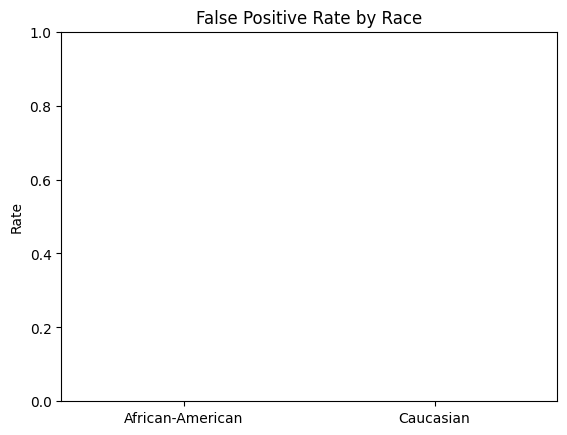

In [29]:
# Convert to DataFrame for plotting
df = dataset_orig.convert_to_dataframe()[0]

# Filter by race and recidivism predictions
african_american = df[df['race'] == 0]
caucasian = df[df['race'] == 1]

# Count false positives
af_fp_rate = len(african_american[(african_american['two_year_recid'] == 0) & 
                                  (african_american['two_year_recid'] > 1)]) / len(african_american)

cau_fp_rate = len(caucasian[(caucasian['two_year_recid'] == 0) & 
                            (caucasian['two_year_recid'] > 4 )]) / len(caucasian)

# Plotting
labels = ['African-American', 'Caucasian']
values = [af_fp_rate, cau_fp_rate]

plt.bar(labels, values, color=['red', 'green'])
plt.title("False Positive Rate by Race")
plt.ylabel("Rate")
plt.ylim(0, 1)
plt.show()


In [22]:
from aif360.algorithms.preprocessing import Reweighing


In [23]:
# Apply reweighing algorithm
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf = RW.fit_transform(dataset_orig)

# Metrics after mitigation
metric_transf = BinaryLabelDatasetMetric(dataset_transf, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)

print("Post-Mitigation Disparate Impact:", metric_transf.disparate_impact())
print("Post-Mitigation Statistical Parity Difference:", metric_transf.statistical_parity_difference())


Post-Mitigation Disparate Impact: 1.0000000000000002
Post-Mitigation Statistical Parity Difference: 1.1102230246251565e-16


In [25]:
from sklearn.preprocessing import StandardScaler


In [2]:
import pandas as pd

# Load the dataset from URL
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
df = pd.read_csv(url)

# Preview the dataset
df.head()


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

# Drop the target from the features and keep only numeric columns
X = df.drop(columns=['two_year_recid'], errors='ignore')
X = X.select_dtypes(include='number')

# Define target
y = df['two_year_recid']

# Create pipeline: impute missing values, then scale
pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),   # or 'median' if more robust
    StandardScaler()
)

# Transform features
X_prepared = pipeline.fit_transform(X)

# Train logistic regression
model = LogisticRegression()
model.fit(X_prepared, y)

# Predict
y_pred = model.predict(X_prepared)




C:\Users\kamog\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\kamog\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\kamog\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values